# How to rediscover the Higgs boson yourself!

Competition entry by Chetan Gohil

# Install modules

In [6]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib keras scikit-learn tensorflow --user

Requirement already up-to-date: pip in /Users/gohil/.local/lib/python3.7/site-packages (19.2.1)
Requirement already up-to-date: numpy in /Users/gohil/.local/lib/python3.7/site-packages (1.16.4)
Requirement already up-to-date: pandas in /Users/gohil/.local/lib/python3.7/site-packages (0.25.0)
Requirement already up-to-date: uproot in /Users/gohil/.local/lib/python3.7/site-packages (3.8.0)
Requirement already up-to-date: matplotlib in /Users/gohil/.local/lib/python3.7/site-packages (3.1.1)
Requirement already up-to-date: keras in /Users/gohil/.local/lib/python3.7/site-packages (2.2.4)
Requirement already up-to-date: scikit-learn in /Users/gohil/.local/lib/python3.7/site-packages (0.21.2)
Requirement already up-to-date: tensorflow in /Users/gohil/.local/lib/python3.7/site-packages (1.14.0)


# Setup necessary modules

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot
import time
import math
import glob
import infofile

import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Global Variables

In [8]:
lumi = 1000
tuple_path = "Input/"
stack_order = ['data',r'$Z,t\bar{t}$','ZZ',r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']
samples = {
    'data': {
        'list' : ['DataEgamma','DataMuons']
    },
    r'$Z,t\bar{t}$' : {
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#8700da"
    },
    'ZZ' : {
        'list' : ['ZZ'],
        'color' : "#f90000"
    },
    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : {
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep'],
        'color' : "#4faeff"
    }
}

# Functions to read in data

In [9]:
def mllll_window(mllll):
    return 120 < mllll < 130

def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_TRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*\
           scaleFactor_TRIGGER

def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

def get_data_from_files():
    data = {}
    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/skim.mc_"
            if s == 'data':
                prefix = "Data/skim."
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".root"
            print(fileString)
            f = glob.glob(fileString,recursive=False)[0]
            if f != "":
                temp = read_file(f,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)
    return data

def read_file(path, sample):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
    data = mc.pandas.df(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type",
               "lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
               "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON",
               "scaleFactor_TRIGGER"], flatten=False)

    nIn = len(data.index)

    if 'Data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,
                                  data.scaleFactor_PILEUP,data.scaleFactor_ELE,
                                  data.scaleFactor_MUON,data.scaleFactor_TRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON",
               "scaleFactor_TRIGGER"], axis=1, inplace=True)

    # calculation of 4-lepton invariant mass
    data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi)

    #
    # Apply cuts
    #
    data = apply_cuts(data)

    # return events with 120 < mllll < 130 GeV
    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

def read_file_bdt(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
    data = mc.pandas.df(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge",
                         "lep_type","lep_etcone20","lep_trackd0pvunbiased",
                         "lep_tracksigd0pvunbiased","mcWeight","scaleFactor_PILEUP",                             "scaleFactor_ELE","scaleFactor_MUON",
                         "scaleFactor_TRIGGER"], flatten=False)

    nIn = len(data.index)

    if 'Data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,
                              data.scaleFactor_PILEUP,data.scaleFactor_ELE,
                              data.scaleFactor_MUON,data.scaleFactor_TRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON",
               "scaleFactor_TRIGGER"], axis=1, inplace=True)

    # cut on number of leptons
    fail = data[ np.vectorize(cut_n_lep)(data.lep_n)].index
    data.drop(fail, inplace=True)

    # calculation of 4-lepton invariant mass
    data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi)

    data.drop(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type",
               "lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased"],
               axis=1, inplace=True)  

    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

def remove_variable_length_columns(data):
    '''formats the data so it can be used in machine learning algorithms'''
    if max(data.lep_n) < 5: 
        df_split = pd.DataFrame(data['lep_pt'].values.tolist(), 
                   columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt'], index=data.index)
        df_split['lep5_pt'] = 0
        df_split['lep6_pt'] = 0
    elif max(data.lep_n) < 6: 
        df_split = pd.DataFrame(data['lep_pt'].values.tolist(),
                   columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt'],
                   index=data.index)
        df_split['lep6_pt'] = 0
    else: df_split = pd.DataFrame(data['lep_pt'].values.tolist(),
                     columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt',
                              'lep6_pt'], index=data.index)
    df_split.fillna(0, inplace=True)
    data = pd.concat([data, df_split], axis=1)
    
    # drop the variables that are of variable length
    data.drop(["lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20",
               "lep_trackd0pvunbiased","lep_tracksigd0pvunbiased"], axis=1,
                inplace=True)  
    
    return data

# Functions to apply cuts

In [10]:
def apply_cuts(data):
    # cut on lepton etcone20
    fail = data[np.vectorize(cut_lep_etcone20)(data.lep_type, data.lep_pt,
                                               data.lep_etcone20)].index
    data.drop(fail, inplace=True)
    print('cut_lep_etcone20:', data.shape)
   
    # cut on lepton d0
    fail = data[np.vectorize(cut_lep_d0)(data.lep_type, data.lep_trackd0pvunbiased,
                                         data.lep_tracksigd0pvunbiased)].index
    data.drop(fail, inplace=True)
    print('cut_lep_d0:', data.shape)

    # cut on deltaR
    fail = data[np.vectorize(cut_deltaR)(data.lep_eta,data.lep_phi)].index
    data.drop(fail, inplace=True)
    print('cut_deltaR:', data.shape)

    # cut on number of leptons
    fail = data[np.vectorize(cut_n_lep)(data.lep_n)].index
    data.drop(fail, inplace=True)
    print('cut_n_lep:', data.shape)

    # cut on lepton charge
    fail = data[np.vectorize(cut_lep_charge)(data.lep_charge)].index
    data.drop(fail, inplace=True)
    print('cut_lep_charge:', data.shape)

    # cut on lepton type
    fail = data[np.vectorize(cut_lep_type)(data.lep_type)].index
    data.drop(fail, inplace=True)
    print('cut_lep_type:', data.shape)

    # cut on lepton pt
    fail = data[np.vectorize(cut_lep_pt)(data.lep_pt)].index
    data.drop(fail, inplace=True)
    print('cut_lep_pt:', data.shape)

    # cut on minimum lepton pt
    fail = data[np.vectorize(cut_lep_pt_min)(data.lep_type, data.lep_pt)].index
    data.drop(fail, inplace=True)
    print('cut_lep_pt_min:', data.shape)

    # calculation of Z boson candidate 1 invariant mass
    data['mZ1'], data['mZ2'] = np.vectorize(calc_mZs)(
                                   data.lep_pt,data.lep_eta,data.lep_phi,
                                   data.lep_charge,data.lep_type)

    # cut on mZ1
    fail = data[np.vectorize(cut_mZ1)(data.mZ1)].index
    data.drop(fail, inplace=True)
    print('cut_mZ1:', data.shape)
 
    # cut on mZ2
    fail = data[np.vectorize(cut_mZ2)(data.mZ2, data.mllll)].index
    data.drop(fail, inplace=True)
    print('cut_mZ2:', data.shape)

    return data

def calc_mllll(lep_pts,lep_etas,lep_phis):
    theta_0 = 2*math.atan(math.exp(-lep_etas[0]))
    theta_1 = 2*math.atan(math.exp(-lep_etas[1]))
    theta_2 = 2*math.atan(math.exp(-lep_etas[2]))
    theta_3 = 2*math.atan(math.exp(-lep_etas[3]))
    p_0 = lep_pts[0]/math.sin(theta_0)
    p_1 = lep_pts[1]/math.sin(theta_1)
    p_2 = lep_pts[2]/math.sin(theta_2)
    p_3 = lep_pts[3]/math.sin(theta_3)
    pz_0 = p_0*math.cos(theta_0)
    pz_1 = p_1*math.cos(theta_1)
    pz_2 = p_2*math.cos(theta_2)
    pz_3 = p_3*math.cos(theta_3)
    px_0 = p_0*math.sin(theta_0)*math.cos(lep_phis[0])
    px_1 = p_1*math.sin(theta_1)*math.cos(lep_phis[1])
    px_2 = p_2*math.sin(theta_2)*math.cos(lep_phis[2])
    px_3 = p_3*math.sin(theta_3)*math.cos(lep_phis[3])
    py_0 = p_0*math.sin(theta_0)*math.sin(lep_phis[0])
    py_1 = p_1*math.sin(theta_1)*math.sin(lep_phis[1])
    py_2 = p_2*math.sin(theta_2)*math.sin(lep_phis[2])
    py_3 = p_3*math.sin(theta_3)*math.sin(lep_phis[3])
    sumpz = pz_0 + pz_1 + pz_2 + pz_3
    sumpx = px_0 + px_1 + px_2 + px_3
    sumpy = py_0 + py_1 + py_2 + py_3
    sumE = p_0 + p_1 + p_2 + p_3
    mllll = sumE**2 - sumpz**2 - sumpx**2 - sumpy**2
    return math.sqrt(mllll)/1000.0

def calc_mll(lep_pts,lep_etas,lep_phis):
    '''arguments are lists containing 2 elements:: 0 = particle 1 and 1 = particle 2'''
    mll = 2*lep_pts[0]*lep_pts[1]
    cosh = math.cosh(lep_etas[0]-lep_etas[1])
    cos = math.cos(lep_phis[0]-lep_phis[1])
    mll *= ( cosh - cos )
    return math.sqrt(mll)/1000.0

def cut_n_lep(lep_n):
    '''only keep events with 4 leptons'''
    return lep_n != 4

def cut_lep_charge(lep_charge):
    '''only keep events with 2 oppositely charged lepton pairs'''
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

def cut_lep_type(lep_type):
    '''only keep events with e-/e+ and mu-/mu+ pairs'''
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 44) \
           and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 48) \
           and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 52)

def cut_lep_pt(lep_pt):
    '''
    remove events where the 2nd highest pt lepton used has lep_pt[1] < 15000
    remove events where the 3rd highest pt lepton used has lep_pt[2] < 10000
    '''
    return lep_pt[1] < 15000 or lep_pt[2] < 10000

def cut_lep_pt_min(lep_type, lep_pt):
    '''
    remove muons with lep_pt < 6000
    remove electrons with lep_pt < 7000
    '''
    cond = []
    for i in range(len(lep_type)):
        if lep_type[i] == 13:
            cond.append(lep_pt[i] < 7000)
        if lep_type[i] == 11:
            cond.append(lep_pt[i] < 6000)
    return True in cond

def cut_deltaR(lep_eta, lep_phi):
    '''cut on deltaR
       want to throw away leptons that are separated from all other leptons by
       deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.2
       want to throw away leptons that are separated from other leptons of the
       same type by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.1
    '''
    delta_eta = []
    for i in range(len(lep_eta)):
        for j in range(len(lep_eta)):
            if i != j:
                delta_eta.append(lep_eta[i] - lep_eta[j])
    delta_phi = []
    for i in range(len(lep_phi)):
        for j in range(len(lep_phi)):
            if i != j:
                delta_phi.append(lep_phi[i] - lep_phi[j])
    deltaR = [math.sqrt(delta_eta[i]**2 + delta_phi[i]**2) < 0.1 \
              for i in range(len(delta_eta))]
    return True in deltaR

def cut_lep_etcone20(lep_type, lep_pt, lep_etcone20):
    '''cut on maximum lepton etcone20
       want to throw away muons with lep_etcone20/lep_pt < 0.3
       want to throw away electrons with lep_etcone20/lep_pt < 0.2
    '''
    cond = []
    for i in range(len(lep_type)):
        if lep_type[i] == 13:
            cond.append(1000*lep_etcone20[i]/lep_pt[i] < 0.3)
        if lep_type[i] == 11:
            cond.append(1000*lep_etcone20[i]/lep_pt[i] < 0.2)
    return True in cond

def cut_lep_d0(lep_type, lep_trackd0pvunbiased, lep_tracksigd0pvunbiased):
    '''
    cut on maximum lepton d0
    want to throw away muons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 3.5
    want to throw away electrons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 6.5
    '''
    cond = []
    for i in range(len(lep_type)):
        if lep_type[i] == 13:
            cond.append(lep_trackd0pvunbiased[i]/lep_tracksigd0pvunbiased[i] > 3.5)
        if lep_type[i] == 11:
            cond.append(lep_trackd0pvunbiased[i]/lep_tracksigd0pvunbiased[i] > 6.5)
    return True in cond

def calc_mZs(lep_pts, lep_etas, lep_phis, lep_charges, lep_types):
    '''calculates the invariant mass of the Z candidates'''
    # classify particles by charge
    neg = np.where(lep_charges==-1)[0]
    pos = np.where(lep_charges==1)[0]

    # invariance masses of the different possible combinations
    mll = []
    combinations = [[0,0], [0,1], [1,0], [1,1]]
    for [i, j] in combinations:
        part1 = neg[i]
        part2 = pos[j]
        if lep_types[part1] == lep_types[part2]:
            pt = [lep_pts[part1], lep_pts[part2]]
            eta = [lep_etas[part1], lep_etas[part2]]
            phi = [lep_phis[part1], lep_phis[part2]]
            mll.append(calc_mll(pt, eta, phi))
    Z1_diff = np.abs([m - 91 for m in mll])
    try:
        Z1_index = Z1_diff.argmin()
        mZ1 = mll[Z1_index]
        if Z1_index in [0, 1, 2]:
            Z2_index = Z1_index + 1
        if Z1_index == 3:
            Z2_index = 0
        mZ2 = mll[Z2_index]
        return mZ1, mZ2
    except:
        # These events correspond to mis-identificated particles
        # they will be removed by cut_mZ1 and cut_mZ2
        return 0, 0

def cut_mZ1(mZ1):
    '''cut on invariant mass of Z boson candidate 1
       want invariant mass of same-type-opposite-charge lepton pair that's closest
       to Z mass (91 GeV) to be in range 50 < m < 106 GeV
    '''
    return mZ1 < 50 or mZ1 > 106

def cut_mZ2(mZ2, mllll):
    '''cut on invariant mass of Z boson candidate 2
       want invariant mass of remaining lepton pair that's closest to Z mass (91 GeV)
       to be in range 17.5 < m < 115 GeV
       advanced: vary the lower range monotically from 17.5 at mllll=120 to 50 at
       mllll=190, and constant above mllll=190
    '''
    # Straight line fit to lower range of mZ2
    gradient = 0.4642857142857143
    intercept = -38.214285714285715
    lower_limit = gradient*mllll + intercept
    return mZ2 < lower_limit or mZ2 > 115

# Function to implement a random forest regression

In [11]:
def forest_regression(data):
    '''finds the most important varibles to use as inputs for a neural network'''
    reg = ske.RandomForestRegressor()

    cleaned_data = remove_variable_length_columns(
                   data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'])
    y = cleaned_data.mllll

    cleaned_data.drop(["mllll"], axis=1, inplace=True)
    X = cleaned_data

    reg.fit(X, y)

    fet_ind = np.argsort(reg.feature_importances_)[::-1]
    fet_imp = reg.feature_importances_[fet_ind]

    plot_forest(data, fet_ind, fet_imp, X, y)

    # Take the 4 most important variables to train the neural network
    nn_input = cleaned_data.columns.values[fet_ind[:4]]

    return nn_input


# Function to implement a deep neural network

In [12]:
def generate_neural_network(mc_data, VARS):
    NDIM = len(VARS)

    X = mc_data[VARS].values
    Y = mc_data['isSignal'].values

    # Split training and testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    # normalise the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # create the model
    model = Sequential()
    model.add(layers.Dense(5, activation='sigmoid', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(3, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # model checkpoint callback
    # saves model architecture + parameters into dense_model.h5
    model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss',
                                        verbose=0, save_best_only=True,
                                        save_weights_only=False, mode='auto',
                                        period=1)

    # Train classifier
    print('Training model')
    history = model.fit(X_train,
                        Y_train,
                        epochs=1000,
                        batch_size=2048,
                        verbose=0,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_split=0.2)

    # plot loss vs epoch and accuracy vs epoch
    plot_loss(history)
    plot_accuracy(history)

    # model checkpoint callback
    # saves model architecture + parameters into dense_model.h5
    model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss',
                                        verbose=0, save_best_only=True,
                                        save_weights_only=False, mode='auto',
                                        period=1)

    # make predictions
    Y_predict = model.predict(X_test)

    # plot ROC
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    plot_roc(fpr, tpr, roc_auc)
    
    return model

# Functions to make plots

In [13]:
def calc_hists(data):
    '''Calculates a histogram of the Monte-Carlo invariant mass and other
        necessary objects'''
    bins = [80 + x*5 for x in range(35) ]

    data_mllll = []
    data_mllll_errors = []

    mc_mllll = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_mllll_window = [] # list for numbers of MC events with 120 < mllll < 130 GeV

    for s in stack_order:
        if s == "data":
            data_mllll,_ = np.histogram(data[s].mllll.values, bins=bins)
            data_mllll_errors = np.sqrt(data_mllll)
        else:
            mc_labels.append(s)
            mc_mllll.append(data[s].mllll.values)
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_mllll_window.append([data[s].totalWeight.values[mllll_iter] \
                for mllll_iter in range(len(data[s].mllll.values)) \
                if 120 < data[s].mllll.values[mllll_iter] < 130])

    return [data_mllll, data_mllll_errors, mc_mllll, mc_labels, mc_colors,
            mc_weights, mc_in_mllll_window]

def plot_data(hists):
    data_mllll = hists[0]
    data_mllll_errors = hists[1]
    mc_mllll = hists[2]
    mc_labels = hists[3]
    mc_colors  = hists[4]
    mc_weights = hists[5]

    data_x = [82.5 + x*5 for x in range(34)]
    bins   = [80 + x*5 for x in range(35)]

    top = np.amax(data_mllll)+math.sqrt(np.amax(data_mllll))

    plt.figure()
    plt.hist(mc_mllll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors,
             label=mc_labels)
    plt.errorbar(x=data_x, y=data_mllll, yerr=data_mllll_errors, fmt='ko', label='Data')
    plt.xlabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',
               horizontalalignment='right',x=1.0,fontsize=11)
    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,
               fontsize=11)
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.05,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",
             family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.05,0.92,'for education only',ha="left",va="top",
             family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.05,0.9,r'$\sqrt{s}=8\,\mathrm{TeV},\;\int L\,dt=1\,\mathrm{fb}^{-1}$',
             ha="left",va="top",family='sans-serif',transform=ax.transAxes)
    plt.legend()
    plt.savefig("events.png")

    return

def plot_loss(history):
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    return

def plot_accuracy(history):
    ax = plt.subplot(2, 2, 2)
    ax.plot(history.history['acc'], label='acc')
    ax.plot(history.history['val_acc'], label='val_acc')
    ax.legend(loc="upper left")
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    return

def plot_roc(fpr, tpr, roc_auc):
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.savefig('metrics.png')
    return

def plot_forest(data, fet_ind, fet_imp, X, y):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    labels = np.array(
             data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'].columns)[fet_ind]
    pd.Series(fet_imp, index=labels).plot('bar', ax=ax)
    ax.set_title('Features importance')
    fig, ax = plt.subplots(1, 1)
    ax.scatter(X['lep1_pt'].values, y, label='lep1')
    ax.scatter(X['lep2_pt'].values, y, label='lep2')
    ax.scatter(X['lep2_pt'].values, y, label='lep3')
    ax.scatter(X['lep3_pt'].values, y, label='lep4')
    ax.set_xlabel('lep_pt [GeV]')
    ax.set_ylabel(r'$M_{\ell\ell\ell\ell}$ [GeV]')
    ax.legend(loc="lower right")
    plt.savefig('forest.png')
    return


# Function to calculate significance

In [14]:
def calc_significance(mc_in_mllll_window):
    # number signal MC events with 120 < mllll < 130 GeV
    N_signal = sum(mc_in_mllll_window[2])

    # number background MC events with 120 < mllll < 130 GeV
    N_background = sum(mc_in_mllll_window[0]+mc_in_mllll_window[1])

    #sig = N_signal/math.sqrt(N_background)
    sig = math.sqrt(2*((N_signal + N_background)*np.log(1.0+N_signal/N_background)-N_signal))

    print('signifiance for 120<mllll<130 = %s' % (sig))

    return sig


# Main function

data:
Input/Data/skim.DataEgamma.root
	Processing: DataEgamma
cut_lep_etcone20: (60, 10)
cut_lep_d0: (45, 10)
cut_deltaR: (37, 10)
cut_n_lep: (37, 10)
cut_lep_charge: (30, 10)
cut_lep_type: (22, 10)
cut_lep_pt: (14, 10)
cut_lep_pt_min: (11, 10)
cut_mZ1: (6, 12)
cut_mZ2: (3, 12)
		Time taken: 0.23403286933898926, nIn: 89, nOut: 3
Input/Data/skim.DataMuons.root
	Processing: DataMuons
cut_lep_etcone20: (58, 10)
cut_lep_d0: (45, 10)
cut_deltaR: (29, 10)
cut_n_lep: (28, 10)
cut_lep_charge: (20, 10)
cut_lep_type: (17, 10)
cut_lep_pt: (9, 10)
cut_lep_pt_min: (5, 10)
cut_mZ1: (5, 12)
cut_mZ2: (4, 12)
		Time taken: 0.12181401252746582, nIn: 112, nOut: 4
$Z,t\bar{t}$:
Input/MC/skim.mc_147770.Zee.root
	Processing: Zee
cut_lep_etcone20: (468, 11)
cut_lep_d0: (342, 11)
cut_deltaR: (313, 11)
cut_n_lep: (309, 11)
cut_lep_charge: (201, 11)
cut_lep_type: (122, 11)
cut_lep_pt: (33, 11)
cut_lep_pt_min: (20, 11)
cut_mZ1: (20, 13)
cut_mZ2: (11, 13)
		Time taken: 0.40763306617736816, nIn: 720, nOut: 11
Inpu

/Users/gohil/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/gohil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
W0723 22:11:49.960590 4712277440 deprecation.py:506] From /Users/gohil/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 22:11:50.110382 4712277440 deprecation.py:323] From

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 25        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________
Training model


W0723 22:12:33.519140 4712277440 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


signifiance for 120<mllll<130 = 0.36980228867737114
Time taken: 61.03127574920654


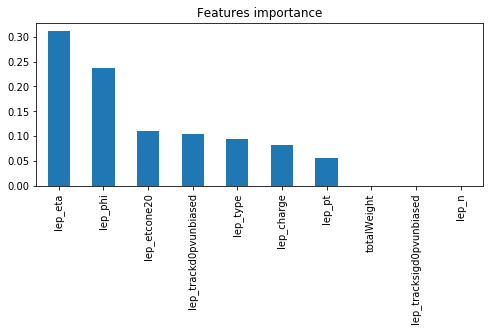

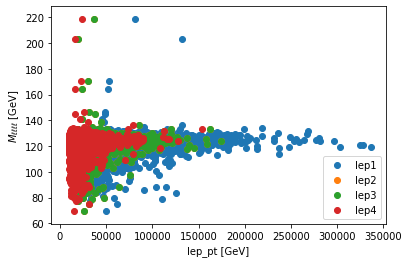

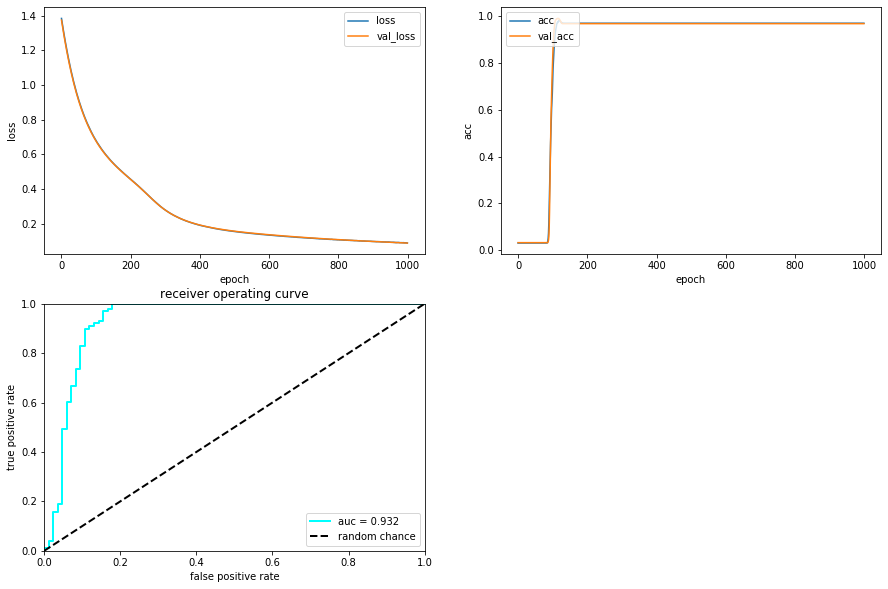

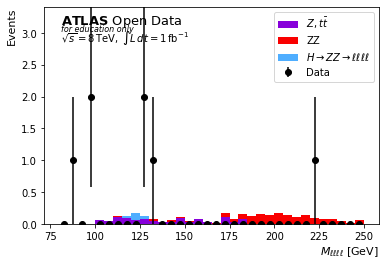

In [15]:
start = time.time()

#
# Get data
#
data = get_data_from_files()

#
# Random forest for feature selection
#
nn_input = forest_regression(data)

#
# Deep Neural Network (for Background Rejection)
#
# add variable to distinugish between signal and background
data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']['isSignal'] = \
     np.ones(len(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']))
data[r'$Z,t\bar{t}$']['isSignal'] = np.zeros(len(data[r'$Z,t\bar{t}$']))
data['ZZ']['isSignal'] = np.zeros(len(data['ZZ']))

# combine all dataframes
all_data = pd.concat([data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'],
                      data[r'$Z,t\bar{t}$'], data['ZZ']])
mc_data = remove_variable_length_columns(all_data)

model = generate_neural_network(mc_data, nn_input)

#
# Make cuts on measurement data using the neural network
#
meas_data = remove_variable_length_columns(data['data'])
X_meas = meas_data[nn_input].values
Y_meas = model.predict(X_meas)
fail = Y_meas < 0.5
data_indices = data['data'].index.values
drop_indices = [data_indices[i] for i in range(len(fail)) if fail[i]]
data['data'].drop(drop_indices, inplace=True)

#
# Plot events histogram
#
hists = calc_hists(data)
plot_data(hists)

# Display the significance
sig = calc_significance(hists[-1])

elapsed = time.time() - start
print("Time taken: "+str(elapsed))